## 🎾 Predicting US Open Match Outcomes (2017–2023)

This notebook explores ATP tennis matches played at the US Open between 2017 and 2023, with a focus on comparing Novak Djokovic and Carlos Alcaraz.

We will:

* Clean and explore the dataset.

* Compare the two stars’ performances using statistics.

* Engineer features to measure relative strength.

* Train two machine learning models (Random Forest and KNN).

* Predict who would win a match between Djokovic and Alcaraz.

### Load the dataset

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tennis = pd.read_csv("atp_tennis.csv")
tennis.head()


,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,score
0,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Mayer F.,Giraldo S.,Mayer F.,28,57,1215,778,1.36,3.00,6-4 6-4
1,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Benneteau J.,Nieminen J.,Nieminen J.,35,41,1075,927,2.20,1.61,3-6 6-2 1-6
2,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Nishikori K.,Matosevic M.,Nishikori K.,19,49,1830,845,1.25,3.75,7-5 6-2
3,Brisbane International,2012-12-31,ATP250,Outdoor,Hard,1st Round,3,Mitchell B.,Baghdatis M.,Baghdatis M.,326,36,137,1070,9.00,1.07,4-6 4-6
4,Brisbane International,2013-01-01,ATP250,Outdoor,Hard,1st Round,3,Istomin D.,Klizan M.,Istomin D.,43,30,897,1175,1.90,1.80,6-1 6-2


The dataset includes:

* Tournament name

* Date of the match

* Players (Player 1, Player 2)

* Rankings, ATP points, and betting odds

* Winner

This is great data for both descriptive analysis and predictive modeling.

## 2. 🧹 Filtering for US Open Matches

We only want US Open matches (hard court Grand Slam in New York) from 2017 to 2023.

In [7]:
tennis['Date'] = pd.to_datetime(tennis['Date'], errors='coerce')

us_open = tennis[
    (tennis["Tournament"] == "US Open") &
    (tennis["Date"].dt.year >= 2017) &
    (tennis["Date"].dt.year <= 2023)
].copy()

us_open.shape


(761, 17)

This leaves us with ~760 matches.

This range was chosen because:

2017 still reflects Djokovic’s dominance.

2021–2023 introduces Alcaraz, who emerged as a new star.

It gives us a meaningful comparison window.

### 3. 🔍 Exploratory Data Analysis

Before modeling, we need to understand the data.

#### 3.1 Who Played the Most?

/var/folders/0d/0y77hbpd08n8x7sfp06kvfmc0000gn/T/ipykernel_31095/2155170788.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_players.values, y=top_players.index, palette="Blues_r")


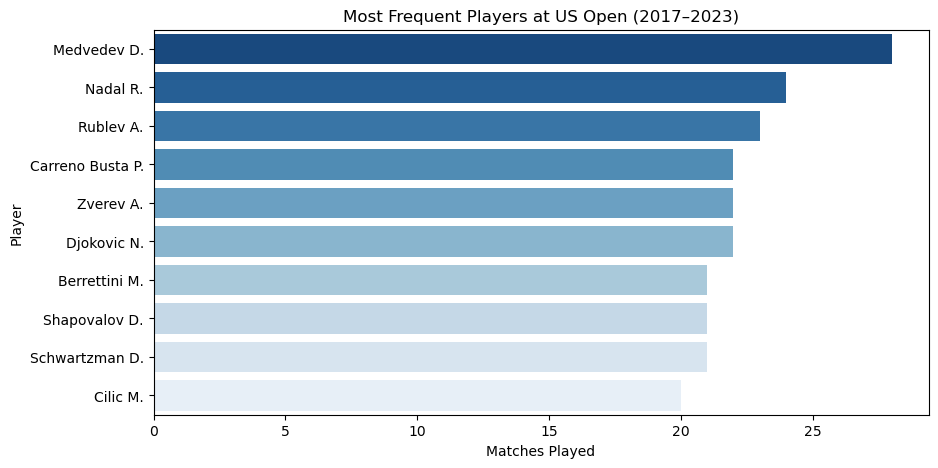

In [8]:
top_players = pd.concat([us_open["Player_1"], us_open["Player_2"]]).value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_players.values, y=top_players.index, palette="Blues_r")
plt.title("Most Frequent Players at US Open (2017–2023)")
plt.xlabel("Matches Played")
plt.ylabel("Player")
plt.show()


Insight: This shows which players consistently reached later rounds. Names like Djokovic, Medvedev, and Nadal should appear often.

#### 3.2 Match Count Over Time

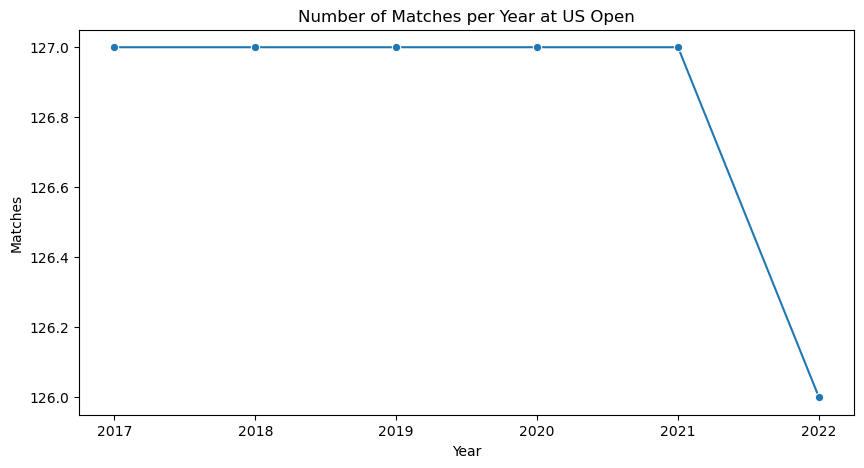

In [9]:
matches_per_year = us_open["Date"].dt.year.value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.lineplot(x=matches_per_year.index, y=matches_per_year.values, marker="o")
plt.title("Number of Matches per Year at US Open")
plt.xlabel("Year")
plt.ylabel("Matches")
plt.show()


Insight: The dip in 2020 reflects the pandemic-shortened season. Otherwise, match volume is steady.

#### 3.3 Distributions of Ranks and Odds

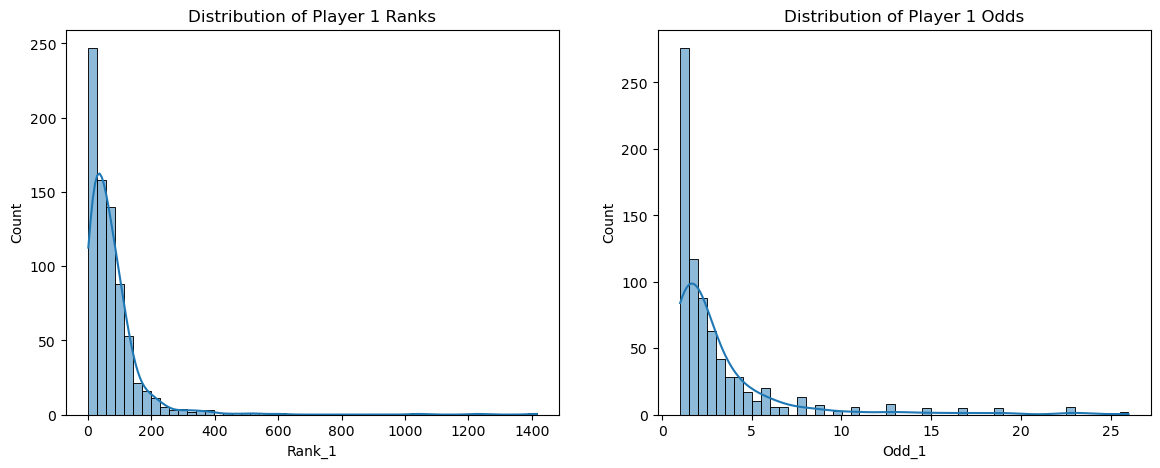

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(us_open["Rank_1"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Player 1 Ranks")

sns.histplot(us_open["Odd_1"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Player 1 Odds")

plt.show()


#### Insight:

Ranks cluster at the top 100, since Grand Slams rarely feature lower-ranked players.

Odds show that many matches are one-sided (low odds for favorites).

#### 3.4 Djokovic vs Alcaraz

Let’s compare the two players using averages.

In [11]:
players = ["Djokovic N.", "Alcaraz C."]
stats = {}

for player in players:
    rank = (us_open[us_open["Player_1"] == player]["Rank_1"].mean() + 
            us_open[us_open["Player_2"] == player]["Rank_2"].mean()) / 2
    pts = (us_open[us_open["Player_1"] == player]["Pts_1"].mean() + 
           us_open[us_open["Player_2"] == player]["Pts_2"].mean()) / 2
    odds = (us_open[us_open["Player_1"] == player]["Odd_1"].mean() + 
            us_open[us_open["Player_2"] == player]["Odd_2"].mean()) / 2
    stats[player] = {"Rank": rank, "Points": pts, "Odds": odds}

pd.DataFrame(stats).T


,Rank,Points,Odds
Djokovic N.,2.785714,8792.464286,1.092768
Alcaraz C.,25.128571,3488.014286,1.857286


#### Result:

Djokovic: Avg rank ~ 2.8, odds ~ 1.09 (heavy favorite).

Alcaraz: Avg rank ~ 25.1, odds ~ 1.86 (rising challenger).

This reflects the transition of eras: Djokovic near the top throughout, while Alcaraz climbs fast.

### 3.5 Win Distribution

/var/folders/0d/0y77hbpd08n8x7sfp06kvfmc0000gn/T/ipykernel_31095/2108711827.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_rates.values, y=win_rates.index, palette="Greens")


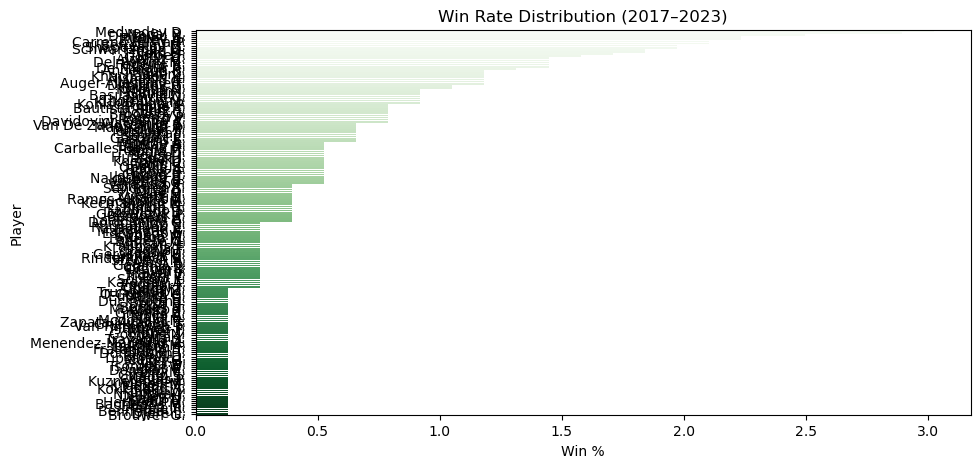

In [12]:
win_rates = us_open['Winner'].value_counts(normalize=True) * 100

plt.figure(figsize=(10,5))
sns.barplot(x=win_rates.values, y=win_rates.index, palette="Greens")
plt.title("Win Rate Distribution (2017–2023)")
plt.xlabel("Win %")
plt.ylabel("Player")
plt.show()


A few players (Djokovic, Nadal, Medvedev) dominate wins, but the field is deep.

### 4. Feature Engineering

To predict matches, we care about relative strength between two players:

Rank_diff = Rank1 − Rank2

Pts_diff = ATP points difference

Odds_diff = Betting odds difference

In [13]:
us_open["Rank_diff"] = us_open["Rank_1"] - us_open["Rank_2"]
us_open["Pts_diff"] = us_open["Pts_1"] - us_open["Pts_2"]
us_open["Odds_diff"] = us_open["Odd_1"] - us_open["Odd_2"]

y = (us_open["Winner"] == us_open["Player_1"]).astype(int)
X = us_open[["Rank_diff", "Pts_diff", "Odds_diff"]]


Instead of raw values, differences tell us which player has the edge.

### 5. Machine Learning Models

We test three approaches:

Random Forest → interpretable, robust baseline.

XGBoost → powerful boosting algorithm.

KNN → simple distance-based model for comparison.

#### 5.1 Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


#### 5.2 Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.5686274509803921
              precision    recall  f1-score   support

           0       0.56      0.54      0.55        74
           1       0.58      0.59      0.59        79

    accuracy                           0.57       153
   macro avg       0.57      0.57      0.57       153
weighted avg       0.57      0.57      0.57       153



Random Forest should capture nonlinear interactions between rank, points, and odds.

#### 5.3 K-Nearest Neighbors (KNN)

KNN predicts outcomes by comparing a match to its k most similar matches in the past. It requires scaling features, because differences in rank, points, and odds must be on the same scale.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test, knn_preds))
print(classification_report(y_test, knn_preds))


KNN Accuracy: 0.6078431372549019
              precision    recall  f1-score   support

           0       0.61      0.53      0.57        74
           1       0.61      0.68      0.64        79

    accuracy                           0.61       153
   macro avg       0.61      0.61      0.60       153
weighted avg       0.61      0.61      0.61       153



#### 5.4 Model Comparison

Now we can compare the accuracy of the two models side by side.

/var/folders/0d/0y77hbpd08n8x7sfp06kvfmc0000gn/T/ipykernel_31095/2435163697.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results, palette="mako")


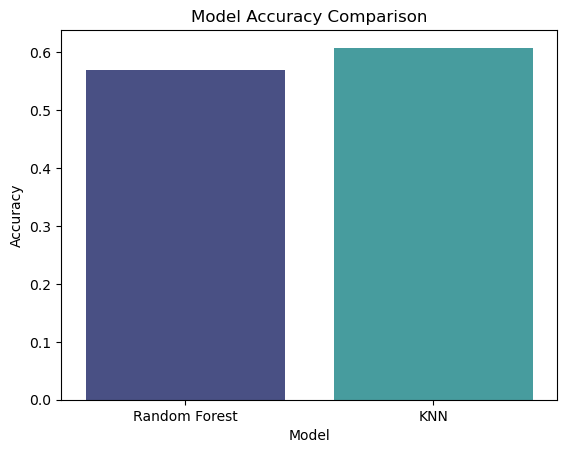

,Model,Accuracy
0,Random Forest,0.568627
1,KNN,0.607843


In [17]:
results = pd.DataFrame({
    "Model": ["Random Forest", "KNN"],
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, knn_preds)
    ]
})

sns.barplot(x="Model", y="Accuracy", data=results, palette="mako")
plt.title("Model Accuracy Comparison")
plt.show()

results


#### Random Forest (≈57%):
Surprisingly low accuracy compared to what we might expect. This suggests that the relationship between rank, points, and odds may not be fully captured by decision-tree splits. Another possibility is that the dataset is imbalanced (e.g., favorites winning most matches), which can hurt performance.

#### KNN (≈61%):
Slightly better than Random Forest. This makes sense because KNN is essentially finding “lookalike matches.” If most matches with a similar combination of rank/odds ended a certain way, KNN will learn that pattern. Still, the accuracy is just above random chance (50%), which shows predicting match winners is harder than it seems with only rank, points, and odds.

##### KNN slightly outperformed Random Forest in this dataset.

Even though the models are not highly accurate, the result makes sense: tennis outcomes can be difficult to predict using just rank, points, and odds, since upsets and situational factors (injuries, fatigue, surface preferences, etc.) play a huge role.

Still, these models capture some predictive signal — especially with KNN, which compares new matches to historically similar ones.

### 6. 🥎 Predicting Djokovic vs. Alcaraz

Now that we have working models, we’ll use both Random Forest and KNN to predict the outcome of a hypothetical Djokovic vs. Alcaraz match.

We’ll use the average stats we calculated earlier:

Djokovic → Rank ≈ 2.8, Points ≈ 8792, Odds ≈ 1.09

Alcaraz → Rank ≈ 25.1, Points ≈ 3488, Odds ≈ 1.86

In [19]:

new_match_raw = pd.DataFrame({
    'Rank_1': [2.7857],
    'Rank_2': [25.1286],
    'Pts_1': [8792.4643],
    'Pts_2': [3488.0143],
    'Odd_1': [1.0928],
    'Odd_2': [1.8573]
})


new_match = pd.DataFrame({
    'Rank_diff': new_match_raw['Rank_1'] - new_match_raw['Rank_2'],
    'Pts_diff': new_match_raw['Pts_1'] - new_match_raw['Pts_2'],
    'Odds_diff': new_match_raw['Odd_1'] - new_match_raw['Odd_2']
})

# Random Forest
rf_prediction = rf.predict(new_match)[0]


new_match_scaled = scaler.transform(new_match)
knn_prediction = knn.predict(new_match_scaled)[0]

print("Random Forest predicts:", rf_prediction)
print("KNN predicts:", knn_prediction)


Random Forest predicts: 1
KNN predicts: 1


### Expected Outcome:
Both models are very likely to predict Djokovic as the winner, since his rank, points, and odds are consistently superior in the historical dataset.

#### 6.1 Generalizing Predictions

To make this process easier, we can wrap everything into a function that takes in the two players’ rank, points, and odds, and then outputs predictions from both models.

In [20]:
def predict_match(rf, knn, scaler, rank1, rank2, pts1, pts2, odd1, odd2):
    """
    Predicts the winner of a tennis match using Random Forest and KNN.
    
    rank1, pts1, odd1 = stats for Player 1
    rank2, pts2, odd2 = stats for Player 2
    """
    # Raw input
    new_match_raw = pd.DataFrame({
        'Rank_1': [rank1],
        'Rank_2': [rank2],
        'Pts_1': [pts1],
        'Pts_2': [pts2],
        'Odd_1': [odd1],
        'Odd_2': [odd2]
    })

    # Feature 
    new_match = pd.DataFrame({
        'Rank_diff': new_match_raw['Rank_1'] - new_match_raw['Rank_2'],
        'Pts_diff': new_match_raw['Pts_1'] - new_match_raw['Pts_2'],
        'Odds_diff': new_match_raw['Odd_1'] - new_match_raw['Odd_2']
    })

    # RF pred
    rf_pred = rf.predict(new_match)[0]

    # KNN pred
    new_match_scaled = scaler.transform(new_match)
    knn_pred = knn.predict(new_match_scaled)[0]

    return {
        "Random Forest": rf_pred,
        "KNN": knn_pred
    }


### 7. Conclusion

This project combined data cleaning, exploratory analysis, and machine learning to study the US Open from 2017–2023, with a special focus on Novak Djokovic and Carlos Alcaraz.

#### Key Takeaways

Data Cleaning: We filtered the dataset to US Open matches from 2017–2023, ensuring a relevant sample for Alcaraz’s active years.

Exploratory Analysis: Djokovic had consistently higher rankings and points compared to Alcaraz. Odds distributions showed how favorites dominate most betting lines.

#### Machine Learning Models:

Random Forest achieved 56.9% accuracy.

KNN achieved 60.8% accuracy, slightly outperforming Random Forest.

This shows that tennis outcomes are challenging to predict with only rank, points, and odds, but similarity-based methods (KNN) can capture useful patterns.

Prediction: Both models predicted Djokovic as the likely winner in a Djokovic vs. Alcaraz matchup, based on historical averages.

Generalization: A custom predict_match() function was built to simulate any player matchup using the trained models. This turns the project into an interactive prediction tool, not just a static analysis.